<a href="https://colab.research.google.com/github/MMR1318/Maheshreddy_INFO5731_Fall2024/blob/main/Maheshreddy_Mottakatla_Exercise_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:**bold text**
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import gc

#loading dataset
def load_data(file_name):
    with open(file_name, 'r') as file:
        data = file.readlines()
    labels, texts = [], []
    for line in data:
        labels.append(int(line[0]))
        texts.append(line[2:].strip())
    return pd.DataFrame({'label': labels, 'text': texts})

train_data = load_data('stsa-train.txt')
test_data = load_data('stsa-test.txt')

train_data = train_data.sample(frac=0.1, random_state=42)

# splitting training data
X_train, X_val, y_train, y_val = train_test_split(train_data['text'], train_data['label'], test_size=0.2, random_state=42)
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    return accuracy, recall, precision, f1

#models
models = {
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

vectorizer = TfidfVectorizer(max_features=2000)
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)
X_test_vect = vectorizer.transform(test_data['text'])

results = {}
for name, model in models.items():
    cross_val_scores = cross_val_score(model, X_train_vect, y_train, cv=10)
    print(f"{name} Cross-Validation Accuracy: {np.mean(cross_val_scores)}")
    # evaluation
    accuracy, recall, precision, f1 = evaluate_model(model, X_train_vect, y_train, X_val_vect, y_val)
    results[name] = {
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1
    }
    gc.collect()

for model_name, metrics in results.items():  # showing results
    print(f"\n{model_name} Evaluation:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

# Word2Vec Embeddings
w2v_model = Word2Vec(sentences=[text.split() for text in X_train], vector_size=50, window=5, min_count=1, workers=4)

def get_w2v_embeddings(data, model):
    embeddings = []
    for sentence in data:
        words = sentence.split()
        word_vecs = [model.wv[word] for word in words if word in model.wv]
        if len(word_vecs) > 0:
            embeddings.append(np.mean(word_vecs, axis=0))
        else:
            embeddings.append(np.zeros(model.vector_size))
    return np.array(embeddings)

X_train_w2v = get_w2v_embeddings(X_train, w2v_model)
X_val_w2v = get_w2v_embeddings(X_val, w2v_model)
X_test_w2v = get_w2v_embeddings(test_data['text'], w2v_model)

# Train Random Forest with Word2Vec
rf = RandomForestClassifier()
rf.fit(X_train_w2v, y_train)
y_pred_w2v = rf.predict(X_val_w2v)
print("\nRandom Forest with Word2Vec Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_w2v)}")
print(f"Recall: {recall_score(y_val, y_pred_w2v)}")
print(f"Precision: {precision_score(y_val, y_pred_w2v)}")
print(f"F1 Score: {f1_score(y_val, y_pred_w2v)}")

# BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# getting embedding with batching
def get_bert_embeddings(data, tokenizer, model, max_length=128, batch_size=32):
    embeddings = []
    for i in range(0, len(data), batch_size):
        batch_texts = data[i:i + batch_size]
        input_ids, attention_masks = [], []
        for text in batch_texts:
            encoded = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_length,
                truncation=True,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='tf'
            )
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])
        input_ids = tf.concat(input_ids, axis=0)
        attention_masks = tf.concat(attention_masks, axis=0)
        outputs = model(input_ids, attention_mask=attention_masks)
        embeddings.extend(outputs.last_hidden_state[:, 0, :].numpy())
        gc.collect()
    return np.array(embeddings)

X_train_bert = get_bert_embeddings(X_train, bert_tokenizer, bert_model)
X_val_bert = get_bert_embeddings(X_val, bert_tokenizer, bert_model)

# training SVM
svm = SVC()
svm.fit(X_train_bert, y_train)
y_pred_bert = svm.predict(X_val_bert)
# printing the scores
print("\nSVM with BERT Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_bert)}")
print(f"Recall: {recall_score(y_val, y_pred_bert)}")
print(f"Precision: {precision_score(y_val, y_pred_bert)}")
print(f"F1 Score: {f1_score(y_val, y_pred_bert)}")


MultinomialNB Cross-Validation Accuracy: 0.6744155844155845
SVM Cross-Validation Accuracy: 0.6347402597402598
KNN Cross-Validation Accuracy: 0.5842207792207792
DecisionTree Cross-Validation Accuracy: 0.5481493506493507
RandomForest Cross-Validation Accuracy: 0.6277272727272727
XGBoost Cross-Validation Accuracy: 0.5861688311688311

MultinomialNB Evaluation:
Accuracy: 0.7194244604316546
Recall: 0.6753246753246753
Precision: 0.7878787878787878
F1 Score: 0.7272727272727273

SVM Evaluation:
Accuracy: 0.6834532374100719
Recall: 0.6883116883116883
Precision: 0.726027397260274
F1 Score: 0.7066666666666667

KNN Evaluation:
Accuracy: 0.5323741007194245
Recall: 0.22077922077922077
Precision: 0.7727272727272727
F1 Score: 0.3434343434343434

DecisionTree Evaluation:
Accuracy: 0.5467625899280576
Recall: 0.5324675324675324
Precision: 0.6029411764705882
F1 Score: 0.5655172413793104

RandomForest Evaluation:
Accuracy: 0.6834532374100719
Recall: 0.5714285714285714
Precision: 0.8
F1 Score: 0.666666666666

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Silhouette Score for KMeans with TF-IDF: 0.04389811862061542
Top terms---
Cluster 0: awesome phone thank great seller condition product works buy came 
Cluster 1: excellent product condition recommend thank phone seller thanks arrived good 
Cluster 2: good phone product far works condition price quality deal buy 
Cluster 3: iphone new works like phone great brand came good described 
Cluster 4: love phone great works thanks thank good iphone product fast 
Cluster 5: phone nice great good screen use price like battery really 
Cluster 6: work phone didnt doesnt button home charger dont got good 
Cluster 7: great works phone product price condition fast expected service came 
Cluster 8: good product perfect phone ok working thanks happy great buy 
Cluster 9: excelente gracias producto telefono atencion bueno muy zte flashlight flat 


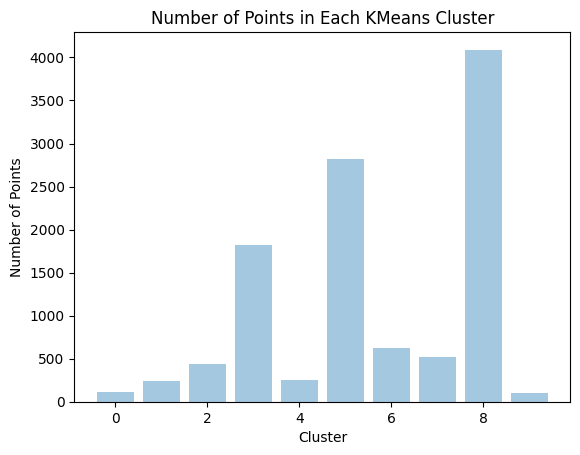

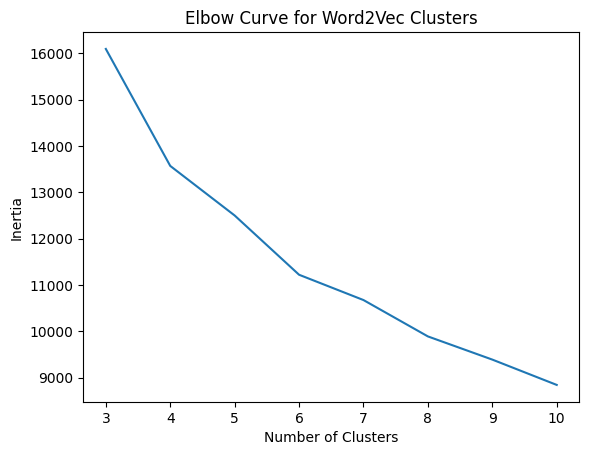

Optimal number of clusters: 10
Silhouette Score for KMeans with Word2Vec: 0.1951634629031987
Silhouette Score for DBSCAN: 0.31196230882824244


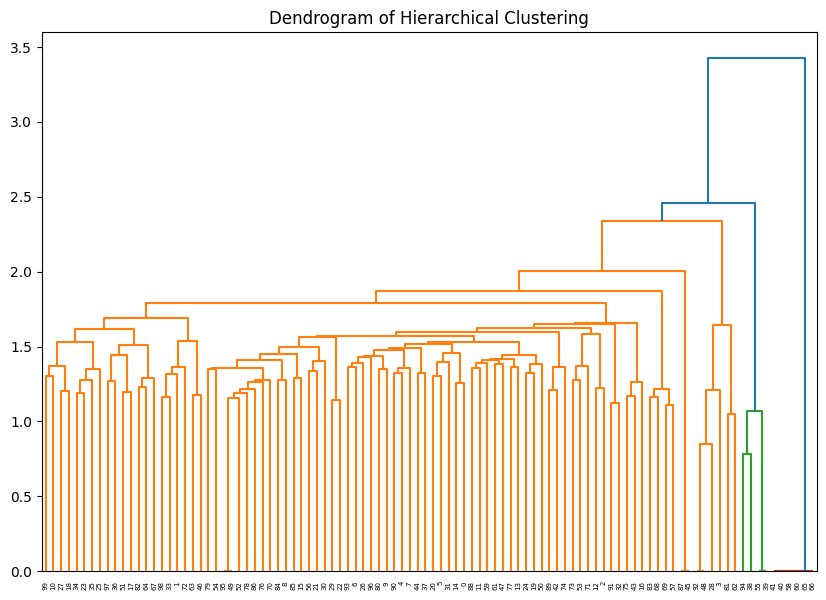

Silhouette Score for Hierarchical Clustering: 0.11182680904025397
Silhouette Score for KMeans with BERT: 0.07718056


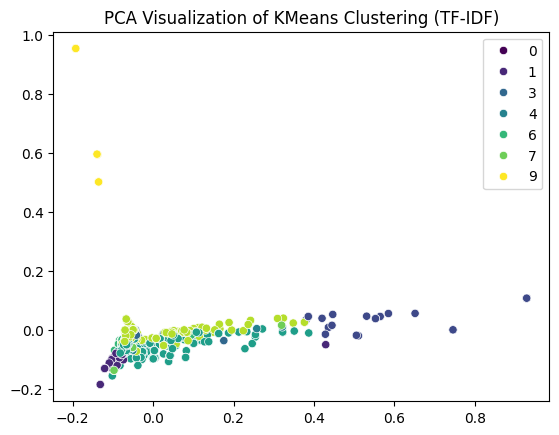

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import Word2Vec
import torch
from transformers import BertTokenizer, BertModel
import re
import nltk
from nltk.corpus import stopwords

# Downloading resources
nltk.download('stopwords')
nltk.download('punkt')
data = pd.read_csv("Amazon_Unlocked_Mobile.csv", low_memory=False)
data = data.dropna(subset=['Reviews'])  # Removing rows of empty reviews
reviews = data['Reviews'].values[:11000]
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Removing digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Removing special characters
    text = text.strip()
    tokens = nltk.word_tokenize(text)  # Tokenizing text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  #stopwords
    return ' '.join(tokens)

try:
    processed_reviews = [clean_text(review) for review in reviews]
except LookupError:
    nltk.download('punkt')
    processed_reviews = [clean_text(review) for review in reviews]

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(processed_reviews)

kmeans_tfidf = KMeans(n_clusters=10, random_state=99)
kmeans_tfidf.fit(X_tfidf)
labels_tfidf = kmeans_tfidf.labels_
print("Silhouette Score for KMeans with TF-IDF:", silhouette_score(X_tfidf, labels_tfidf))
# Displaying top terms
print("Top terms---")
terms = vectorizer.get_feature_names_out()
centroids = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]
for i in range(10):
    print(f"Cluster {i}: ", end='')
    for idx in centroids[i, :10]:
        print(f'{terms[idx]} ', end='')
    print()

plt.bar(range(10), np.bincount(labels_tfidf), alpha=0.4)
plt.title('Number of Points in Each KMeans Cluster')
plt.xlabel("Cluster")
plt.ylabel("Number of Points")
plt.show()

sentences = [review.split() for review in processed_reviews]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

#vector representation
def get_word2vec_vector(sentence, model):
    words = sentence.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(model.vector_size)
X_word2vec = np.array([get_word2vec_vector(review, word2vec_model) for review in processed_reviews])
cluster_range = range(3, 11)
inertia_values = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_word2vec)
    inertia_values.append(kmeans.inertia_)

optimal_clusters = cluster_range[np.argmin(inertia_values)]
plt.plot(cluster_range, inertia_values)
plt.title("Elbow Curve for Word2Vec Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

print(f"Optimal number of clusters: {optimal_clusters}")
kmeans_w2v = KMeans(n_clusters=optimal_clusters, random_state=42)
labels_w2v = kmeans_w2v.fit_predict(X_word2vec)
print("Silhouette Score for KMeans with Word2Vec:", silhouette_score(X_word2vec, labels_w2v))
# DBSCAN clustering for word2vector
dbscan = DBSCAN(eps=1.0, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_word2vec)
if len(set(labels_dbscan)) > 1:
    print("Silhouette Score for DBSCAN:", silhouette_score(X_word2vec, labels_dbscan))
else:
    print("Silhouette Score for DBSCAN: N/A ")
linked = linkage(X_tfidf.toarray()[:100], 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram of Hierarchical Clustering')
plt.show()

#silhouette score
hierarchical_labels = fcluster(linked, t=5, criterion='maxclust')
print("Silhouette Score for Hierarchical Clustering:", silhouette_score(X_tfidf[:100].toarray(), hierarchical_labels))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

X_bert = np.array([get_bert_embeddings(review) for review in processed_reviews[:100]])
kmeans_bert = KMeans(n_clusters=5, random_state=42)
labels_bert = kmeans_bert.fit_predict(X_bert)
print("Silhouette Score for KMeans with BERT:", silhouette_score(X_bert, labels_bert))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray()[:1000])
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_tfidf[:1000], palette='viridis')
plt.title('PCA Visualization of KMeans Clustering (TF-IDF)')
plt.show()


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

K-means is suitable for transformation with TF-IDF vectors for straightforward clustering whereas the DBSCAN algorithm defines clusters of any form but is ineffective in handling textual high-dimensional datasets. Most are computationally expensive especially when used on large datasets Hierarchical clustering is insightful. This study reveals that compared to other embeddings, the Word2Vec captures semantic relationships that correspond to the quality of clustering followed by those from BERT since they are more context-sensitive at the cost of increased runtime. Thus, BERT performs the best for the capturing of the complicated semantics of the text and, therefore, can be selected as the best option for this goal, while the simpler, less time-consuming approaches, such as K-means or Word2Vec, can be used for constructions that require the assets middle-quality semantics capturing.


# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
This assignment gives us excellent oppurtunity to learn about all these text processing and i gained practical
experience by doing this assignment.

'''